**Notre centre d'intérêt c'est le groupe des personnes qui vont churn. En considérant ce groupe de churners, notre objectif , c'est quoi?**

C'est que:


1. **Sur 100 personnes de ce groupe , que le modéle prédise le plus grand nombre de churners: le recall. Ainsi, l'on pourra mener une politique de rétention sinon on perd en clients**;
2. **Si le modèle prédit que 100 sont churners, que le plus grand nombre soit réellement des churners: la précision. Ainsi, l'on pourra optimiser notre budget prévu pour la politique de rétention et ne pas dépenser sur des clients qui ne vont pas réellement quitter.**

# PARAMETRAGE

In [10]:
%pip install dill imblearn pendulum ucimlrepo yellowbrick loguru

Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
from pathlib import Path

import dill
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pendulum
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from imblearn.pipeline import Pipeline as imb_Pipeline
from loguru import logger
from sklearn import set_config
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix,
                             classification_report,
                             ConfusionMatrixDisplay,
                             roc_auc_score,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             RocCurveDisplay,
                             PrecisionRecallDisplay,
                            )
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder, OneHotEncoder
from ucimlrepo import fetch_ucirepo, list_available_datasets
from yellowbrick.classifier import DiscriminationThreshold

set_config(display='diagram')
pd.set_option("display.max_columns", None)


In [12]:
def afficher_dataframes(dfs, head_n=5):
    """
    Affiche les informations d'un DataFrame ou d'un dictionnaire de DataFrames.

    Paramètres :
    - dfs : un DataFrame ou un dictionnaire {nom: DataFrame}
    - head_n : nombre de lignes à afficher avec head()
    """

    if isinstance(dfs, pd.DataFrame):
        # Cas d’un seul DataFrame
        print(f"\n📄 DESCRIPTION")
        print(f"📐 Taille : {dfs.shape[0]} lignes × {dfs.shape[1]} colonnes")
        print(f"🧠 Colonnes : {dfs.columns.tolist()}")
        display(dfs.head(head_n))

    elif isinstance(dfs, dict):
        if not dfs:
            print("⚠️ Dictionnaire vide.")
            return

        for name, df in dfs.items():
            if isinstance(df, pd.DataFrame):
                print(f"\n📄 Nom : {name}")
                print(f"📐 Taille : {df.shape[0]} lignes × {df.shape[1]} colonnes")
                print(f"🧠 Colonnes : {df.columns.tolist()}")
                display(df.head(head_n))
            else:
                print(f"⚠️ L’objet '{name}' n’est pas un DataFrame.")

    else:
        print("❌ Entrée non valide : fournir un DataFrame ou un dictionnaire de DataFrames.")


In [13]:
train_df=pd.read_csv("../data/cleaned data/train_df.csv")

# MODELISATION

L’objectif est souvent de détecter les clients susceptibles de partir, pour permettre à la banque d’agir (fidélisation, offres personnalisées, etc.). Cela implique :

    Le coût d’un faux négatif (FN) (client qui part mais n’est pas détecté) est plus élevé que celui d’un faux positif (FP).

## Data preparation

In [14]:
afficher_dataframes(train_df)


📄 DESCRIPTION
📐 Taille : 165034 lignes × 14 colonnes
🧠 Colonnes : ['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [15]:
train_df.drop(['id',
           'CustomerId',
           "Surname"
       ], axis=1, inplace=True)
afficher_dataframes(train_df)


📄 DESCRIPTION
📐 Taille : 165034 lignes × 11 colonnes
🧠 Colonnes : ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


## Train / test split

In [16]:
x_values = train_df.drop(columns=['Exited'])  
y_target = train_df.Exited

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x_values, y_target, test_size=0.2, random_state=42, stratify=y_target)

In [18]:
afficher_dataframes(x_train)


📄 DESCRIPTION
📐 Taille : 132027 lignes × 10 colonnes
🧠 Colonnes : ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
112149,726,France,Female,35.0,1,0.00,2,1.0,1.0,141466.85
70095,481,France,Female,37.0,8,152303.66,2,1.0,0.0,175082.20
29247,583,France,Female,35.0,5,0.00,1,0.0,0.0,102581.11
161355,644,France,Female,32.0,7,0.00,2,1.0,0.0,77965.67
105992,709,France,Male,29.0,5,128548.49,1,1.0,1.0,140941.47


In [19]:
y_train.value_counts(normalize=True).mul(100).round(2)

Exited
0    78.84
1    21.16
Name: proportion, dtype: float64

### Feature engineering

In [20]:
afficher_dataframes(x_values)


📄 DESCRIPTION
📐 Taille : 165034 lignes × 10 colonnes
🧠 Colonnes : ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83


In [21]:
# numerical
numeric_features = x_values.select_dtypes(include="number").columns
# categorical
onehot_features = ['Gender',"Geography"]

In [23]:
afficher_dataframes(x_train.loc[:, numeric_features])


📄 DESCRIPTION
📐 Taille : 132027 lignes × 8 colonnes
🧠 Colonnes : ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
112149,726,35.0,1,0.00,2,1.0,1.0,141466.85
70095,481,37.0,8,152303.66,2,1.0,0.0,175082.20
29247,583,35.0,5,0.00,1,0.0,0.0,102581.11
161355,644,32.0,7,0.00,2,1.0,0.0,77965.67
105992,709,29.0,5,128548.49,1,1.0,1.0,140941.47


In [24]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='undefined')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', onehot_transformer, onehot_features)
])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='undefined',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Gender', 'Geography'])])

## Modeling

#### Dummy regressor

In [25]:
# Pipeline
dm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', DummyClassifier())
])

dm_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Geography'])])),
                ('clf', DummyClassifier())])

In [26]:
# Training
dm_pipeline.fit(x_train, y_train)

# Predictions & evaluation
dm_y_pred_test = dm_pipeline.predict(x_test)
dm_y_proba_test = dm_pipeline.predict_proba(x_test)[:, 1]

logger.info(f"AUC: {roc_auc_score(y_test, dm_y_proba_test):.2f}")
logger.info(f"Classification report: \n{classification_report(y_test, dm_y_pred_test)}")

2025-06-06 00:57:59.876 | INFO     | __main__:<module>:8 - AUC: 0.50
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

#### Logistic regression

In [27]:
# Pipeline
rl_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])
rl_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Geography'])])),
                ('clf', LogisticRegression(max_iter=1000))])

##### Baseline

In [28]:
# 8. Entraînement
rl_pipeline.fit(x_train, y_train)

# 9. Prédictions & évaluation
rl_y_pred_test = rl_pipeline.predict(x_test)
rl_y_proba_test = rl_pipeline.predict_proba(x_test)[:, 1]

logger.info(f"AUC: {roc_auc_score(y_test, rl_y_proba_test):.2f} ")
logger.info(f"Classification report: \n{classification_report(y_test, rl_y_pred_test)}")

2025-06-06 00:58:10.454 | INFO     | __main__:<module>:8 - AUC: 0.81 
2025-06-06 00:58:10.615 | INFO     | __main__:<module>:9 - Classification report: 
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     26023
           1       0.69      0.38      0.49      6984

    accuracy                           0.83     33007
   macro avg       0.77      0.67      0.70     33007
weighted avg       0.82      0.83      0.81     33007



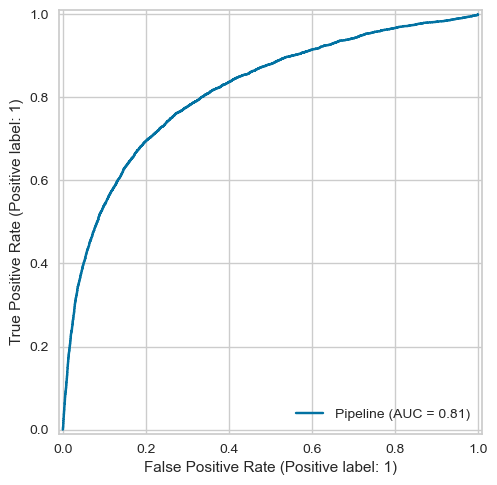

In [29]:
RocCurveDisplay.from_estimator(rl_pipeline, x_test, y_test);

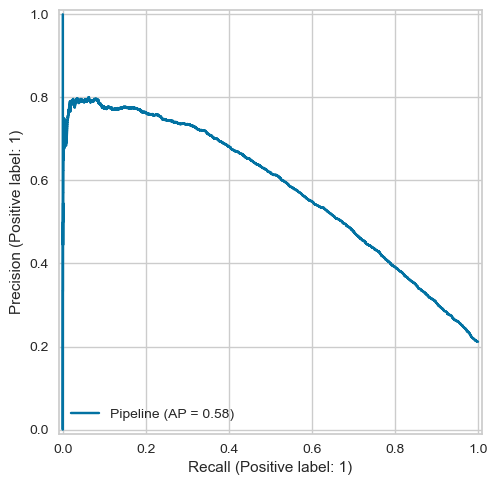

In [30]:
PrecisionRecallDisplay.from_estimator(rl_pipeline, x_test, y_test);


##### Tuning hyperparameters

In [31]:
rl_param_grid = {
    "clf__penalty": ["l2"],  # 'l1' si solver = 'liblinear' ou 'saga'
    "clf__C": [0.01, 0.1, 1, 2, 3, 5, 10],
    "clf__solver": ['liblinear', 'lbfgs', "sag", "saga"],  # lbfgs ne supporte que l2
    "clf__class_weight": ['balanced', None],
}

In [ ]:
# Cross-validation
cv = StratifiedKFold(n_splits=5) 
rl_grid_search = GridSearchCV(rl_pipeline, rl_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)

# Training
rl_grid_search.fit(x_train, y_train)

# Best params
logger.info(f"Best params : {rl_grid_search.best_params_}")

# Evaluation
rl_y_pred_test_opt = rl_grid_search.predict(x_test)
rl_y_proba_test_opt  = rl_grid_search.predict_proba(x_test)[:, 1]

logger.info(f"AUC : {roc_auc_score(y_test, rl_y_proba_test_opt):.2f}")
logger.info(f"F1-score : {f1_score(y_test, rl_y_pred_test_opt):.2f}")
logger.info(f"Accuracy : {accuracy_score(y_test, rl_y_pred_test_opt):.2f}")


2025-06-06 01:25:01.437 | INFO     | __main__:<module>:9 - Best params : {'clf__C': 0.01, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
2025-06-06 01:25:01.690 | INFO     | __main__:<module>:15 - AUC : 0.82
2025-06-06 01:25:01.724 | INFO     | __main__:<module>:16 - F1-score : 0.56
2025-06-06 01:25:01.736 | INFO     | __main__:<module>:17 - Accuracy : 0.75


In [33]:
data_lift = pd.DataFrame({"y_true": y_test, "y_pred": rl_y_pred_test_opt, "proba": rl_y_proba_test_opt})
data_lift = data_lift.sort_values("proba", ascending=False).reset_index(drop=True)
data_lift.head()

,y_true,y_pred,proba
0,0,1,0.996049
1,1,1,0.992339
2,0,1,0.991908
3,0,1,0.991192
4,1,1,0.988672


In [34]:
# Decile
data_lift["decile"] = pd.qcut(data_lift.index, 10, labels=False)
data_lift.head()# features importances

,y_true,y_pred,proba,decile
0,0,1,0.996049,0
1,1,1,0.992339,0
2,0,1,0.991908,0
3,0,1,0.991192,0
4,1,1,0.988672,0


In [35]:

# Global positive rate
global_positive_rate =  data_lift["y_true"].sum() / len(data_lift)
global_positive_rate

0.2115914805950253

In [36]:
lift_aggregate_table = data_lift.groupby("decile")["y_true"].agg(["sum","count"])
lift_aggregate_table["cum_positives"] = lift_aggregate_table["sum"].cumsum()

lift_aggregate_table["positive_rate_cum"] = lift_aggregate_table["cum_positives"] / lift_aggregate_table["count"].cumsum()
lift_aggregate_table["lift_score"] = lift_aggregate_table["positive_rate_cum"] / global_positive_rate

lift_aggregate_table["percent_sample"] = 10 * (lift_aggregate_table.index + 1)

lift_aggregate_table

,sum,count,cum_positives,positive_rate_cum,lift_score,percent_sample
decile,,,,,,
0,2321,3301,2321,0.703120,3.323008,10
1,1494,3301,3815,0.577855,2.730995,20
2,1005,3300,4820,0.486770,2.300520,30
3,619,3301,5439,0.411952,1.946921,40
4,468,3301,5907,0.357913,1.691530,50
5,345,3300,6252,0.315694,1.491997,60
6,254,3301,6506,0.281584,1.330791,70
7,223,3300,6729,0.254838,1.204387,80
8,134,3301,6863,0.231031,1.091872,90


In [37]:
px.line(
    lift_aggregate_table,
    x="percent_sample",
    y="lift_score",
    labels={
        "percent_sample": "Cumulative % of Sample",
        "lift_score": "Lift Score"
    },
    title="Lift Curve"
)

##### Discrimination threshold

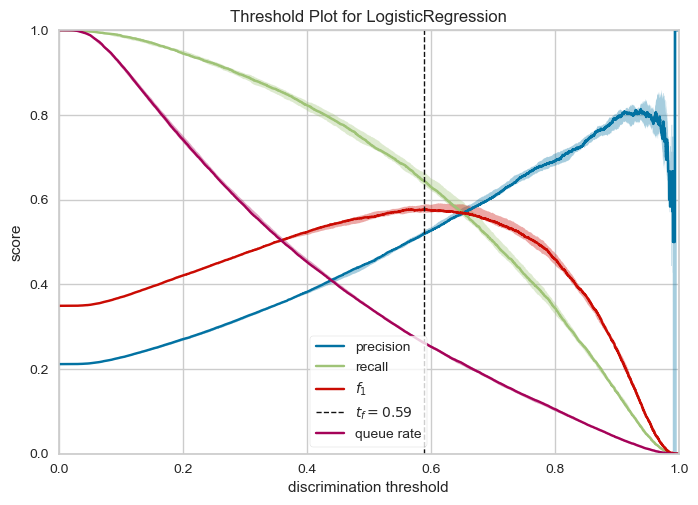

In [38]:
viz = DiscriminationThreshold(rl_grid_search.best_estimator_, random_state=42, fbeta=1.0, cv=cv, argmax="fscore")

viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show();

In [39]:
best_threshold_rl=0.59
logger.info(f"Best threshold:{best_threshold_rl}")

2025-06-06 02:01:21.471 | INFO     | __main__:<module>:2 - Best threshold:0.59


In [40]:
print(classification_report(y_test,rl_y_pred_test_opt))

              precision    recall  f1-score   support

           0       0.91      0.76      0.83     26023
           1       0.45      0.73      0.56      6984

    accuracy                           0.75     33007
   macro avg       0.68      0.75      0.69     33007
weighted avg       0.82      0.75      0.77     33007



In [41]:
# Evaluation avec seuil
rl_y_proba_test_opt = rl_grid_search.predict_proba(x_test)[:, 1]
rl_y_pred_test_opt = (rl_y_proba_test_opt >= best_threshold_rl).astype(int)

logger.info(f"AUC : {roc_auc_score(y_test, rl_y_proba_test_opt):.2f}")
logger.info(f"F1-score : {f1_score(y_test, rl_y_pred_test_opt):.2f}")
logger.info(f"Accuracy : {accuracy_score(y_test, rl_y_pred_test_opt):.2f}")

2025-06-06 02:02:59.197 | INFO     | __main__:<module>:5 - AUC : 0.82
2025-06-06 02:02:59.221 | INFO     | __main__:<module>:6 - F1-score : 0.57
2025-06-06 02:02:59.229 | INFO     | __main__:<module>:7 - Accuracy : 0.80


##### Save model

In [48]:
output_dir = "saved_models"  # nom du dossier
output_dir_fina = "final_model" 
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_dir_fina, exist_ok=True)
model_path = os.path.join(output_dir, "rl_model.pkl")

with open(model_path, "wb") as fp:
    dill.dump(rl_grid_search.best_estimator_, fp)


### KNN

#### Baseline

In [44]:
# Pipeline
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', KNeighborsClassifier(n_neighbors=10))
])

knn_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Geography'])])),
                ('clf', KNeighborsClassifier(n_neighbors=10))])

In [45]:
# 8. Entraînement
knn_pipeline.fit(x_train, y_train)

# 9. Prédictions & évaluation
knn_y_pred_test = knn_pipeline.predict(x_test)
knn_y_proba_test = knn_pipeline.predict_proba(x_test)[:, 1]


logger.info(f"AUC: {roc_auc_score(y_test, knn_y_proba_test):.2f}")

logger.info(f"Classification report: \n{classification_report(y_test, knn_y_pred_test)}")

2025-06-06 02:14:54.588 | INFO     | __main__:<module>:9 - AUC: 0.85
2025-06-06 02:14:54.696 | INFO     | __main__:<module>:11 - Classification report: 
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     26023
           1       0.75      0.49      0.59      6984

    accuracy                           0.86     33007
   macro avg       0.81      0.72      0.75     33007
weighted avg       0.85      0.86      0.84     33007



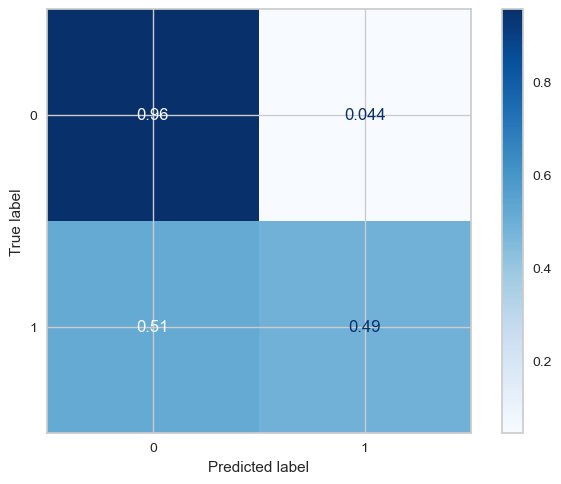

In [46]:
class_names = np.unique(y_test)
ConfusionMatrixDisplay.from_estimator(knn_pipeline, x_test, y_test,
                                      display_labels=class_names,
                                      normalize="true", cmap=plt.cm.Blues);

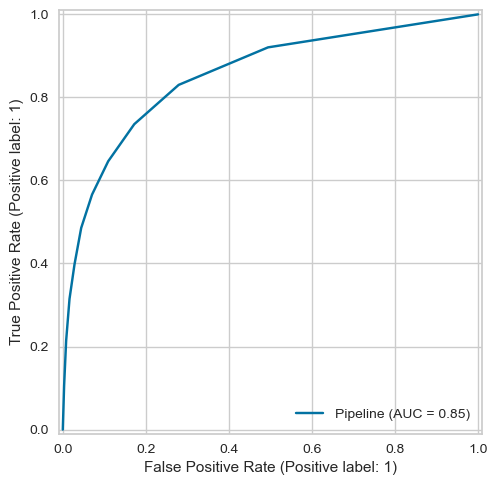

In [47]:
RocCurveDisplay.from_estimator(knn_pipeline, x_test, y_test);

## Modeles Ensembliste

### Random forest

### Gradient Boosting

### XgBoost
